<a href="https://colab.research.google.com/github/shauryasachdev/Vizuara_CV/blob/main/Linear_NN_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

import os
PROJECT = "plated-shelter-464511-f9" # REPLACE WITH YOUR PROJECT ID
BUCKET = "bucket_ml_ss" # REPLACE WITH YOUR BUCKET NAME
REGION = "asia" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.19"  # Tensorflow version


In [2]:
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [7]:
from google.colab import drive
drive.mount('/content/drive')  # Mounts Drive at /content/drive/

# Set your desired Drive path (creates folder if it doesn't exist)
drive_path = '/content/drive/MyDrive/Colab Notebooks/flower_dataset/'

# Download and extract directly to the Drive path
archive = tf.keras.utils.get_file(
    'flower_photos.tgz',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    cache_dir=drive_path,  # Saves here instead of local cache
    extract=True
)

# Your exact path as Path object
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Verify
image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")  # Should be 3670

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.is_dir()]
)
print("These are the available classes:", CLASS_NAMES)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 3670 images.
These are the available classes: ['dandelion' 'daisy' 'tulips' 'roses' 'sunflowers']


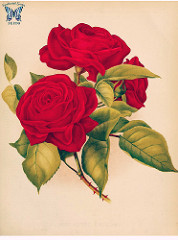

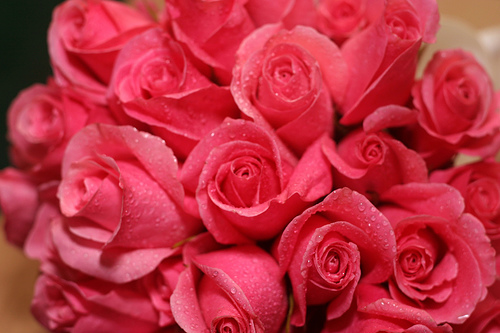

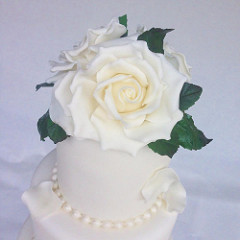

In [8]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [9]:
import random
import glob

# Your Drive path to the flower_photos folder with class subdirs
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Collect all image paths and labels from Drive (local paths)
all_images = []
for class_name in CLASS_NAMES:
    class_dir = data_dir / class_name
    images = glob.glob(str(class_dir / '*.jpg'))
    for img in images:
        all_images.append(f"{img},{class_name}")

# Shuffle and split into train/eval (80/20)
random.shuffle(all_images)
num_total = len(all_images)
num_train = int(0.8 * num_total)
train_lines = all_images[:num_train]
eval_lines = all_images[num_train:]

# Write CSVs to Drive (using data_dir as base)
train_csv_path = os.path.join(str(data_dir), 'train_set.csv')
eval_csv_path = os.path.join(str(data_dir), 'eval_set.csv')

with open(train_csv_path, 'w') as f:
    f.write('\n'.join(train_lines))
with open(eval_csv_path, 'w') as f:
    f.write('\n'.join(eval_lines))

# Verify: Print first 5 lines of train CSV using shell (with quoted path to avoid syntax errors)
!head -5 "{train_csv_path}"

/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/4764674741_82b8f93359_n.jpg,roses
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/tulips/6931748252_68f06086b3.jpg,tulips
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/daisy/14698531521_0c2f0c6539.jpg,daisy
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/2535466393_6556afeb2f_m.jpg,roses
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/3475572132_01ae28e834_n.jpg,roses


In [10]:
Img_Height = 224
Img_Width = 224
Img_Channels = 3

Batch_Size = 32

def read_and_decode(filename, resize_dims):
  # Read the raw file
  img_bytes = tf.io.read_file(filename)
  # Decode the image data
  img = tf.image.decode_jpeg(img_bytes, channels=Img_Channels)
  # Convert the pixel values to float in [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to desired dimensions
  img = tf.image.resize(img, resize_dims)
  return img

In [11]:
def parse_csvline(csv_line):
  # record_defaults specify the data types for each column
  record_default = ["", ""]
  filename, label_string = tf.io.decode_csv(csv_line, record_default)

  # Load the image
  img = read_and_decode(filename, [Img_Height, Img_Width])

  # Conver label string to integer based on the Class_Names index
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [16]:
train_dataset = (
    tf.data.TextLineDataset(train_csv_path)
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset(eval_csv_path)
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [17]:
# Test iteration
for image_batch, label_batch in train_dataset.take(1):
    print("Image Batch Shape:", image_batch.shape)
    print("Label Batch Shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image Batch Shape: (16, 224, 224, 3)
Label Batch Shape: (16,)
Labels: [3 2 1 3 3 3 2 0 3 4 0 1 2 4 4 4]


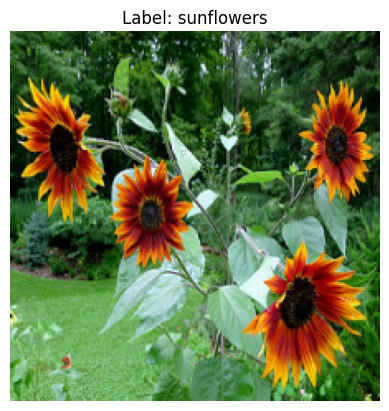

In [18]:
for image_batch, label_batch in eval_dataset.take(1):
  first_image = image_batch[0]
  first_label = label_batch[0]

  # convert tensor to numpy array
  plt.imshow(first_image.numpy())
  plt.title(f"Label: {CLASS_NAMES[first_label]}")
  plt.axis('off')
  plt.show()

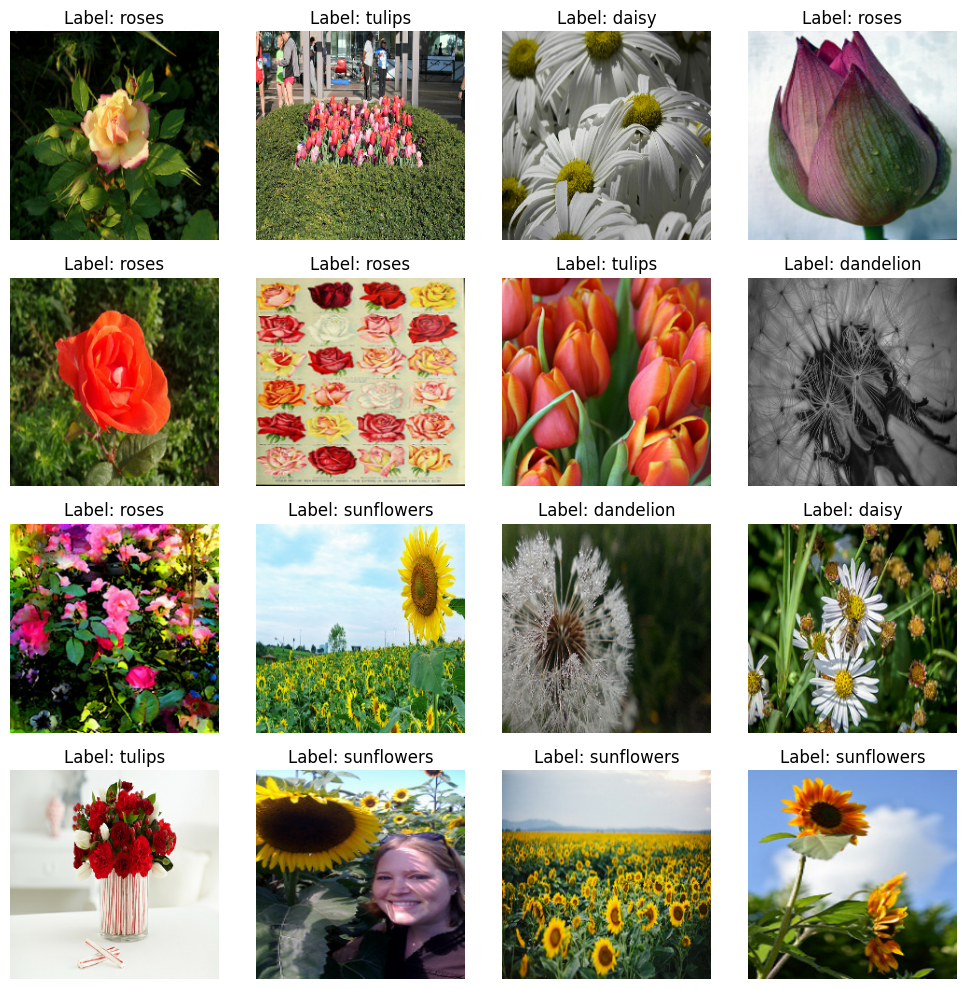

In [21]:
for image_batch, label_batch in train_dataset.take(1):
  fig, axes = plt.subplots(4,4, figsize=(10,10))

  for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(image_batch[i].numpy())
    ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(Img_Height, Img_Width, Img_Channels)),
    keras.layers.Dense(len(CLASS_NAMES), activation = "softmax")
])

model.compile(
    optimizer = "adam",
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
EPOCHS = 10

histor = model.fit(
    train_dataset,
    validation_data = eval_dataset,
    epochs = EPOCHS
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    184/Unknown 23s 117ms/step - accuracy: 0.2945 - loss: 20.2894

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.2947 - loss: 20.2546 - val_accuracy: 0.3774 - val_loss: 11.9097
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.4024 - loss: 10.1140 - val_accuracy: 0.3488 - val_loss: 14.1078
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.4466 - loss: 10.9727 - val_accuracy: 0.3992 - val_loss: 10.8421
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 207ms/step - accuracy: 0.4511 - loss: 10.3032 - val_accuracy: 0.4046 - val_loss: 8.7221
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 229ms/step - accuracy: 0.4891 - loss: 10.0102 - val_accuracy: 0.2779 - val_loss: 32.8661
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.4879 - loss: 13.1897 - val_accuracy: 0.3406 - val_loss: 21.0775
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 77s 422ms/step - accuracy: 0.5224 - loss: 10.3392 - val_accuracy: 0.3065 - val_loss: 22.7859
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.5223 - loss:

<function matplotlib.pyplot.show(close=None, block=None)>

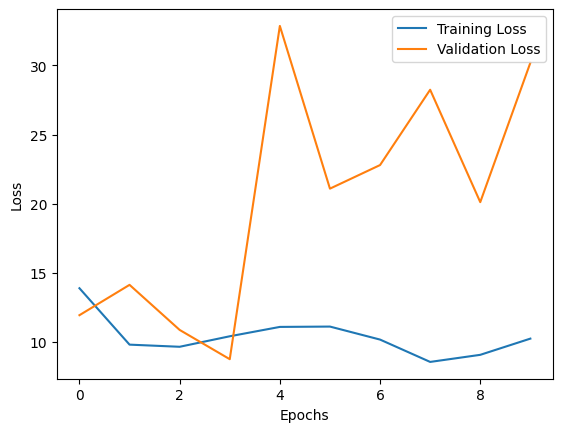

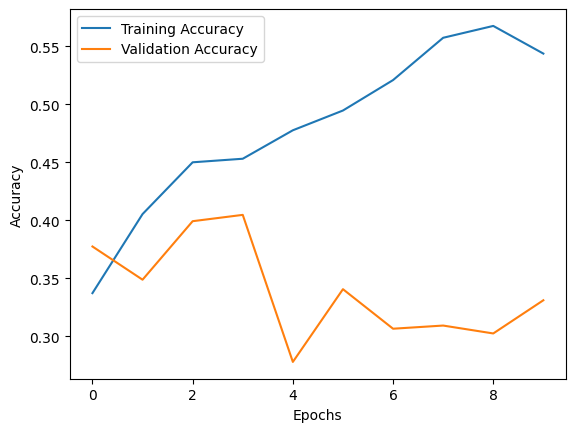

In [31]:
plt.figure()
plt.plot(histor.history["loss"], label="Training Loss")
plt.plot(histor.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

plt.figure()
plt.plot(histor.history["accuracy"], label="Training Accuracy")
plt.plot(histor.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


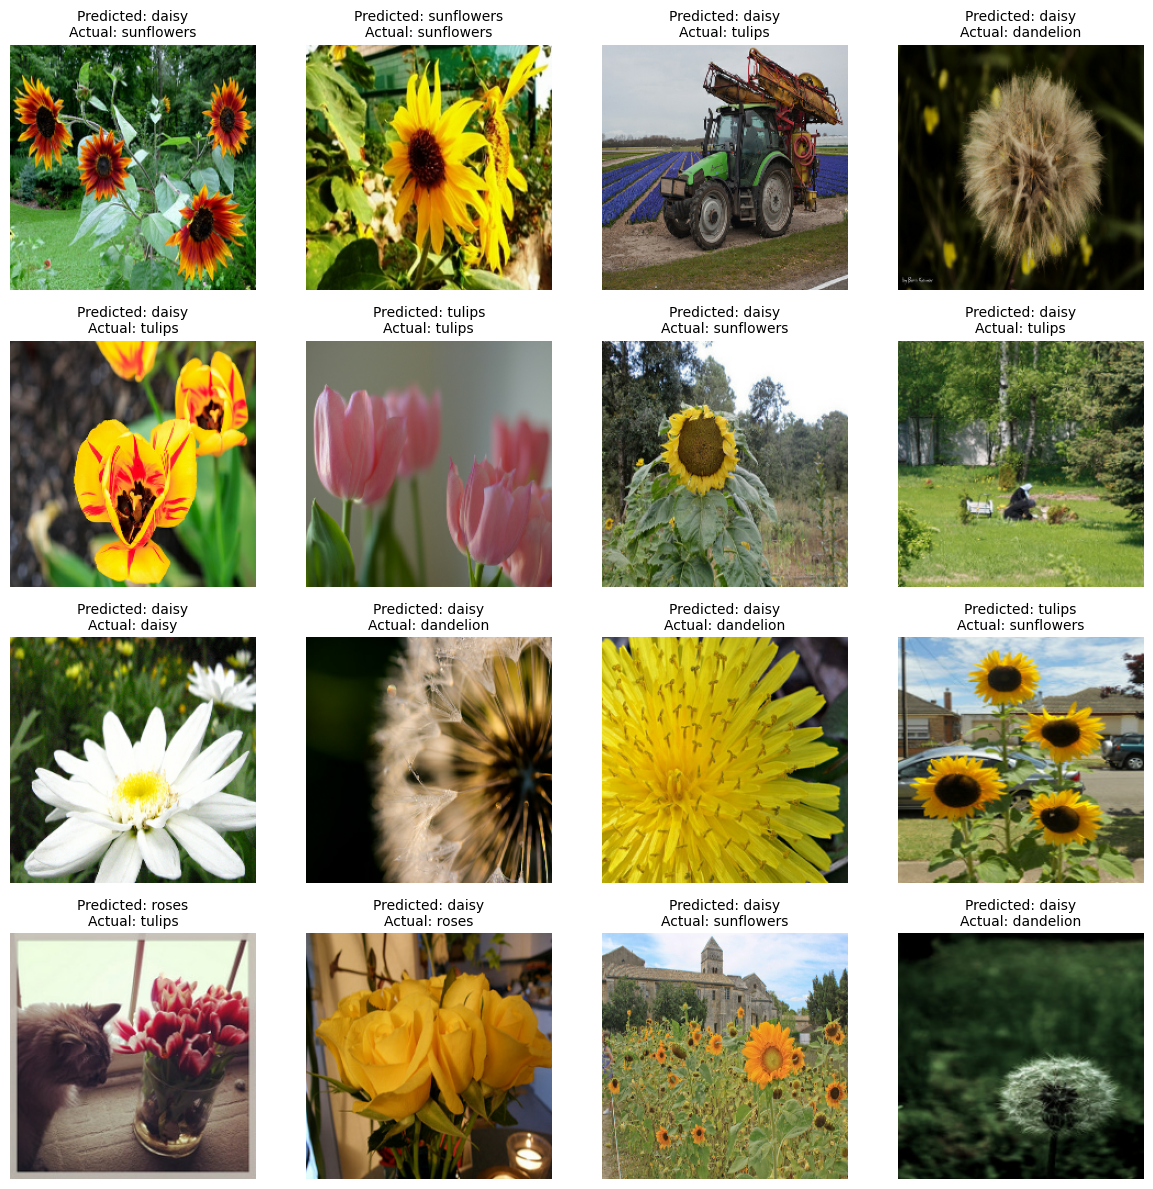

In [32]:
import math

for images, labels in eval_dataset.take(1):
  batch_predictions = model.predict(images)
  predicted_indices = np.argmax(batch_predictions, axis = 1)

  num_images = images.shape[0]
  num_cols = 4
  num_rows = math.ceil(num_images / num_cols)

  plt.figure(figsize=(12,3*num_rows))

  for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    pred_class = CLASS_NAMES[predicted_indices[i]]
    actual_class = CLASS_NAMES[labels[i].numpy()]

    plt.title(f"Predicted: {pred_class}\nActual: {actual_class}", fontsize = 10)

  plt.tight_layout()
  plt.show